In [1]:
import tweepy
import webbrowser
from tweepy import Stream
from tweepy.streaming import StreamListener
from tweepy import Cursor
from tweepy import API
import pandas as pd
import numpy as np
import re
from textblob import Word, TextBlob
import matplotlib.pyplot as plt
import json
# from wordcloud import WordCloud

In [2]:
# We shall be analysing tweets with respect to presidential debate

with open('data/manager.json') as f:
    data = json.load(f)
    consumer_key = data['API_key']
    consumer_secret = data['API_secret_Key']
    Bearer_Token = data['Bearer_Token']


callback_url= 'oob'
auth= tweepy.OAuthHandler(consumer_key,consumer_secret,callback_url) # Authenticate our User
redirect_url = auth.get_authorization_url() # Get URL to direct user
# print(redirect_url)
webbrowser.open(redirect_url)
user_pint_input = input ("What's the pin value? ")
user_pint_input
auth.get_access_token(user_pint_input)
api= tweepy.API(auth, wait_on_rate_limit=True)
me = api.me()

In [3]:
# Setting up tweeter handler

hashtag = '#covid-19'
query = tweepy.Cursor(api.search, q=hashtag,lang='en').items(1000)  # The search method will help us search
# print(dir(query)) 
tweets = [ {'Tweets':tweet.text, 'Timestamp':tweet.created_at} for tweet in query]
# print(tweets)

In [4]:
print(dir(query)) 

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'current_page', 'limit', 'next', 'num_tweets', 'page_index', 'page_iterator', 'prev']


In [5]:
# Import tweets into a data frame
# convert dictionary to list
tweets = list(tweets) 
df = pd.DataFrame(tweets, columns=['Tweets','Timestamp'])
# print(df)

In [6]:

# Cleaning tweets
def clean_text(raw_text):
    raw_text = re.sub(r'@[A-Za-z0-9]+','',raw_text) # Remove all @mentions and numbers
    raw_text = re.sub(r'#','',raw_text) # Remove the # symbol
    raw_text = re.sub(r'RT[\s]+','',raw_text) # Removing the RT
    raw_text = re.sub(r'https?:\/\/\S+','',raw_text) # Remove hyper links
    raw_text = re.sub(r':','',raw_text)
    raw_text = re.sub(r'_','',raw_text)
    raw_text = re.sub(r'\n\n','',raw_text)
    raw_text = re.sub(r'--&','',raw_text)
    raw_text = re.sub(r'\n','',raw_text)
    return raw_text

df['Tweets'] = df['Tweets'].apply(clean_text)

# print(df)
#print(df.shape)

In [7]:
# Remove emorjis
def removeEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df['Tweets'] = df['Tweets'].apply(removeEmojify)

# print(df)

In [8]:
# Plot the word cloud
# allword = ' '.join([twts for twts in df['Tweets']])
# wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allword)
# plt.imshow(wordCloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [9]:
# Subjectivity and the polarity

# How much a piece of text is based on emotion or how objective or subjective it is ranging from 0 to 1
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# How positive or negative something is ranging from -1 to 1
def getPolarity(text): 
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# print(df)

In [10]:
# Create a new function to compute negative, neutral and positive analysis

def getAnalysys(score):
        if score<0:
            return 'Negative'
        elif score==0:
            return 'Neutral'
        else:
            return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysys)

# print(df)

In [11]:
 # print all positive tweets
# print('*****Positive Tweets*****')
j = 1
sortedDF = df.sort_values(by=['Polarity']) # sorts value by polarity
for i in range(0,sortedDF.shape[0]): # looping through number of rows
    if (sortedDF['Analysis'][i]=='Positive'): # print if Analysis column is positive
            # print(str(j) + ')'+ sortedDF['Tweets'][i])
            # print()
            j +=1

In [12]:
# print all negative tweets
# print('*****Negative Tweets*****')
j = 1
sortedDF = df.sort_values(by=['Polarity'], ascending='False')
for i in range(0,sortedDF.shape[0]):
     if (sortedDF['Analysis'][i]=='Negative'):
            # print(str(j) + ')'+ sortedDF['Tweets'][i])
            # print()
            j +=1

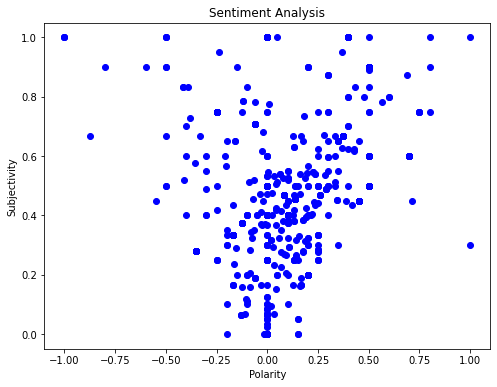

In [13]:
# Plot Polarity vs Subjectivity
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polarity'][i],df['Subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [14]:

 # Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']
percent = round((ptweets.shape[0] / df.shape[0]) * 100, 1)
print(f'Positive tweets %: {percent}')


# Get the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']
percent = round((ntweets.shape[0] / df.shape[0]) * 100, 1)
print(f'Negative tweets %: {percent}')

Positive tweets %: 35.6
Negative tweets %: 18.6


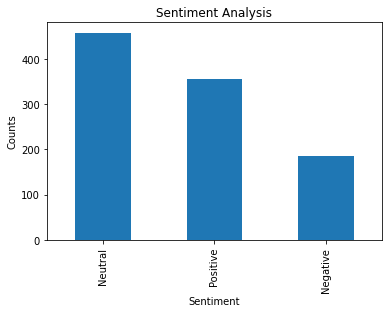

In [15]:
# Show value counts

df['Analysis'].value_counts()

# Plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind='bar')
plt.show()